In [44]:
from __future__ import absolute_import, division, print_function

import os
import base64
import imageio
import IPython
import PIL.Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

import argparse

from tensorflow import keras
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Enables TensorFlow 2 behaviors.
tf.compat.v1.enable_v2_behavior()

In [6]:
def dqn_args_train():
    """Parse DQN training arguments.
    
    Returns:
        args: The parsed arguments.
    """
    parser = argparse.ArgumentParser()

    parser.add_argument(
        '--seed',
        dest='seed',
        type=int,
        help='Seed for numpy and tensorflow.',
        default=123)

    parser.add_argument(
        '--num_iterations',
        dest='num_iterations',
        type=int,
        help=' Training will end after n number of interations.',
        default=20000)

    parser.add_argument(
        '--initial_collect_steps',
        dest='initial_collect_steps',
        type=int,
        help='Exploratory steps.',
        default=1000)

    parser.add_argument(
        '--collect_steps_per_iteration',
        dest='collect_steps_per_iteration',
        type=int,
        help='Collected steps per iteration.',
        default=1)

    parser.add_argument(
        '--replay_buffer_max_length',
        dest='replay_buffer_max_length',
        type=int,
        help='Size of the replay buffer.',
        default=100000)

    parser.add_argument(
        '--batch_size',
        dest='batch_size',
        type=int,
        help='The assets directory.',
        default=64)

    parser.add_argument(
        '--lr',
        dest='learning_rate',
        type=float,
        help='The learning rate',
        default=1e-3)

    parser.add_argument(
        '--log_interval',
        dest='log_interval',
        type=int,
        help='Output logs after n steps.',
        default=200)

    parser.add_argument(
        '--num_eval_episodes',
        dest='num_eval_episodes',
        type=int,
        help='.',
        default=10)

    parser.add_argument(
        '--eval_interval',
        dest='eval_interval',
        type=int,
        help='.',
        default=1000)

    args = parser.parse_args(args=[])
    #args = parser.parse_args()

    return args

In [7]:
env_name = 'BreakoutDeterministic-v4'
env = suite_gym.load(env_name)

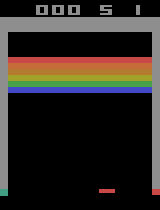

In [8]:
env.reset()
PIL.Image.fromarray(env.render())

In [9]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)


In [10]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [15]:
print('Reward Spec:')
print(env.time_step_spec())

Reward Spec:
TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))


In [11]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


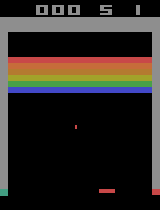

In [20]:
time_step = env.reset()
action = np.array(1, dtype=np.int32)
next_time_step = env.step(action)

PIL.Image.fromarray(env.render())

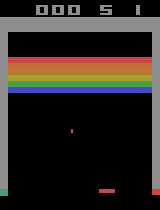

In [21]:
env.step(action)
PIL.Image.fromarray(env.render())

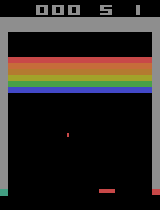

In [22]:
env.step(action)
PIL.Image.fromarray(env.render())

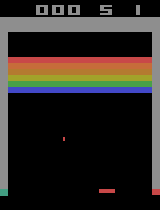

In [23]:
env.step(action)
PIL.Image.fromarray(env.render())

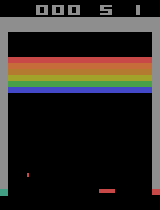

In [26]:
env.step(action)
env.step(action)
env.step(action)
PIL.Image.fromarray(env.render())

In [27]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

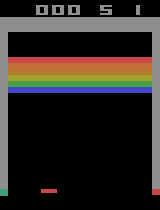

In [30]:
action = np.array(3, dtype=np.int32)
env.step(action)
env.step(action)
env.step(action)
PIL.Image.fromarray(env.render())

In [34]:
def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

In [37]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [33]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4
# import cv2

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

Saving figure preprocessed_breakout_plot


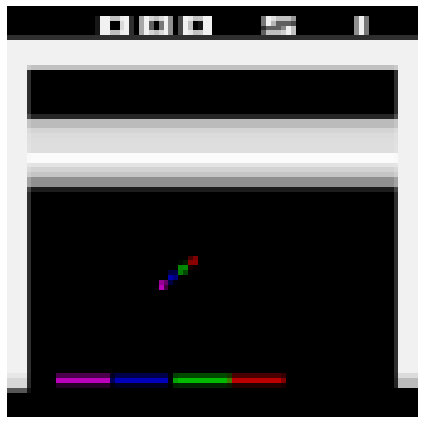

In [41]:
env.seed(42)
env.reset()
IMAGES_PATH = 'imgs'
time_step = env.step(np.array(1, dtype=np.int32)) # FIRE
for _ in range(4):
    time_step = env.step(np.array(3, dtype=np.int32)) # LEFT
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig("preprocessed_breakout_plot")
plt.show()

In [42]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

In [45]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)

conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

In [46]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# see TF-agents issue #113
#optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
#                                     epsilon=0.00001, centered=True)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

In [47]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

In [48]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [49]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [50]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [51]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

In [52]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


20000/20000

In [53]:
tf.random.set_seed(888) # chosen to show an example of trajectory at the end of an episode

trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)

In [54]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [55]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [56]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [57]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

Saving figure sub_episodes_plot


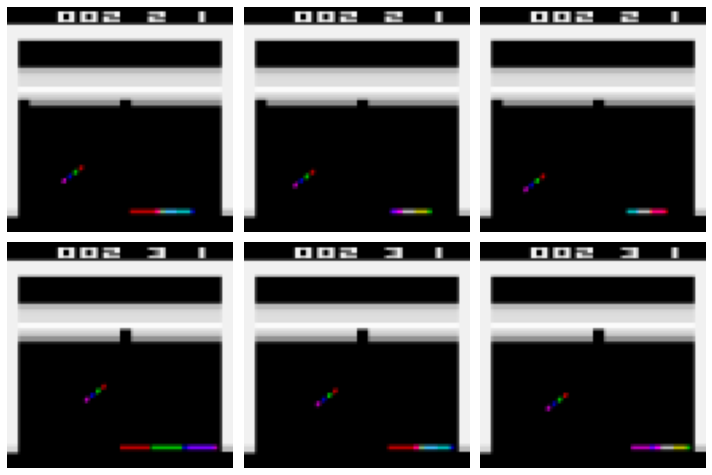

In [58]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

In [59]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [60]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [62]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)
        if iteration % 1000*2 == 0:
            create_policy_eval_video(agent.policy, "videos/breakout_" + str(step), tf_env, env)

In [63]:
train_agent(n_iterations=10000)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


996 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 4004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 174.60000610351562


1997 loss:0.00760

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 8004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 191.3000030517578


2997 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 69
		 EnvironmentSteps = 12004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 165.60000610351562


3996 loss:0.01573

INFO:absl: 
		 NumberOfEpisodes = 91
		 EnvironmentSteps = 16004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 195.60000610351562


4995 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 114
		 EnvironmentSteps = 20004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 165.6999969482422


5998 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 137
		 EnvironmentSteps = 24004
		 AverageReturn = 0.699999988079071
		 AverageEpisodeLength = 161.0


6995 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 161
		 EnvironmentSteps = 28004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 179.1999969482422


7997 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 184
		 EnvironmentSteps = 32004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 167.0


8999 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 206
		 EnvironmentSteps = 36004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 177.10000610351562


9999 loss:0.00741

In [79]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [80]:
def create_policy_eval_video(policy, filename, eval_env, eval_py_env, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)

In [ ]:
create_policy_eval_video(agent.policy, "videos/breakout_" + str(1), tf_env, env)

In [ ]:
embed_mp4('videos/breakout_1.mp4')

In [76]:
tf_env.pyenv.envs[0].ALE

AttributeError: 'AtariPreprocessing' object has no attribute 'ALE'

In [78]:
tf_env.unwrapped

AttributeError: 'BatchedPyEnvironment' object has no attribute 'unwrapped'

In [67]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs.render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs.ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs.ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

AttributeError: 'list' object has no attribute 'ale'

In [65]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

IndexError: list index out of range

In [66]:
%%html
<img src="images/rl/breakout.gif" />